In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import scipy.signal as signal
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

wesad_df = pd.read_csv('PSI.csv')
wesad_df

,subject,label,ecg,eda,temp,resp,acc_x,acc_y,acc_z
0,S2,0,0.034173,5.181544,30.247377,-1.218021,0.969442,-0.257653,-0.534531
1,S2,0,-0.096356,5.177953,30.247078,-0.468897,0.835454,-0.103890,-0.274835
2,S2,0,-0.094738,5.811486,30.235842,0.957831,0.860602,-0.131935,-0.322404
3,S2,0,0.062564,6.407475,30.247667,-0.300775,0.852237,-0.126013,-0.309526
4,S2,0,0.069053,6.234022,30.246643,0.902375,0.852700,-0.121735,-0.305027
...,...,...,...,...,...,...,...,...,...
86863,S17,0,0.012518,7.185380,32.704660,6.548665,0.891498,-0.032677,-0.172980
86864,S17,0,-0.013845,7.182819,32.015800,-1.343822,0.897371,-0.034048,-0.150464
86865,S17,0,-0.010492,7.186100,32.800050,-5.516638,0.895874,-0.040864,-0.153063
86866,S17,0,0.003404,7.188020,32.136555,-5.366044,0.893502,-0.044590,-0.159368


In [2]:
# ----------------------------
# Prepare data for training
# ----------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Keep only 1, 2, and 4 (baseline, stress, meditation)
wesad_df = wesad_df[wesad_df["label"].isin([1, 2, 4])].reset_index(drop=True)

subject_ids = [f"S{i}" for i in range(2, 18)]  # S2–S17
test_subjects = ["S15", "S16", "S17"]  # held out for testing
train_subjects = [s for s in subject_ids if s not in test_subjects]


# Split by subject
train_df = wesad_df[wesad_df["subject"].isin(train_subjects)]
test_df = wesad_df[wesad_df["subject"].isin(test_subjects)]

print(f"Train subjects: {train_subjects}")
print(f"Test subjects: {test_subjects}")
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

# Features
features = ["ecg", "eda", "temp", "resp", "acc_x", "acc_y", "acc_z"]

X_train = train_df[features].values
y_train = train_df["label"].values
X_test = test_df[features].values
y_test = test_df["label"].values

# ✅ Remap labels to 0, 1, 2
label_encoder = {1: 0, 2: 1, 4: 2}  # baseline=0, stress=1, meditation=2
y_train = np.vectorize(label_encoder.get)(y_train)
y_test = np.vectorize(label_encoder.get)(y_test)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to small sequences for LSTM (e.g. 60s windows)
window = 60  # 60 timesteps = 1 minute
stride = 2 # 50% overlap

def make_sequences(X, y, window, stride):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - window, stride):
        X_seq.append(X[i:i+window])
        # majority label in window
        vals, counts = np.unique(y[i:i+window], return_counts=True)
        y_seq.append(vals[np.argmax(counts)])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = make_sequences(X_train, y_train, window, stride)
X_test_seq, y_test_seq = make_sequences(X_test, y_test, window, stride)

print(f"Train seq: {X_train_seq.shape}, Test seq: {X_test_seq.shape}")

# One-hot encode labels
num_classes = len(np.unique(y_train_seq))
y_train_cat = to_categorical(y_train_seq, num_classes)
y_test_cat = to_categorical(y_test_seq, num_classes)

print(f"Number of classes: {num_classes} → {label_encoder}")


Train subjects: ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14']
Test subjects: ['S15', 'S16', 'S17']
Train shape: (22259, 9), Test shape: (5659, 9)
Train seq: (11100, 60, 7), Test seq: (2800, 60, 7)
Number of classes: 3 → {1: 0, 2: 1, 4: 2}


In [3]:
# %%
# ----------------------------
# Build CNN + LSTM classifier
# ----------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, Dense,
    Dropout, BatchNormalization, Flatten
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    LSTM(128, return_sequences=True),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 64)            2304      
                                                                 
 batch_normalization (Batch  (None, 60, 64)            256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 30, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 128)           24704     
                                                                 
 batch_normalization_1 (Bat  (None, 30, 128)          

In [4]:
# ----------------------------
# Train model
# ----------------------------
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("best_wesad_classifier.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_seq, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, checkpoint, lr_reduce],
    verbose=1
)

Epoch 1/50


138/139 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.7302
Epoch 1: val_accuracy improved from -inf to 0.55676, saving model to best_wesad_classifier.keras
139/139 [==============================] - 15s 55ms/step - loss: 0.6903 - accuracy: 0.7305 - val_loss: 0.9834 - val_accuracy: 0.5568 - lr: 5.0000e-04
Epoch 2/50
139/139 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.9146
Epoch 2: val_accuracy improved from 0.55676 to 0.63514, saving model to best_wesad_classifier.keras
139/139 [==============================] - 7s 49ms/step - loss: 0.2688 - accuracy: 0.9146 - val_loss: 1.1104 - val_accuracy: 0.6351 - lr: 5.0000e-04
Epoch 3/50
138/139 [============================>.] - ETA: 0s - loss: 0.1946 - accuracy: 0.9417
Epoch 3: val_accuracy improved from 0.63514 to 0.64955, saving model to best_wesad_classifier.keras
139/139 [==============================] - 7s 50ms/step - loss: 0.1943 - accuracy: 0.9417 - val_loss: 1.3812 - val

In [5]:
# %%
# ----------------------------
# Evaluate model
# ----------------------------
best_model = tf.keras.models.load_model("best_wesad_classifier.keras")
loss, acc = best_model.evaluate(X_test_seq, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {acc*100:.2f}%")

# Predictions
y_pred = np.argmax(best_model.predict(X_test_seq), axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
target_names = ["baseline", "stress", "meditation"]
print(classification_report(y_test_seq, y_pred, target_names=target_names))


Test Accuracy: 66.14%
88/88 [==============================] - 2s 10ms/step

Classification Report:
              precision    recall  f1-score   support

    baseline       0.83      0.73      0.78      1873
      stress       0.16      0.28      0.20       306
  meditation       0.65      0.64      0.64       621

    accuracy                           0.66      2800
   macro avg       0.54      0.55      0.54      2800
weighted avg       0.71      0.66      0.68      2800



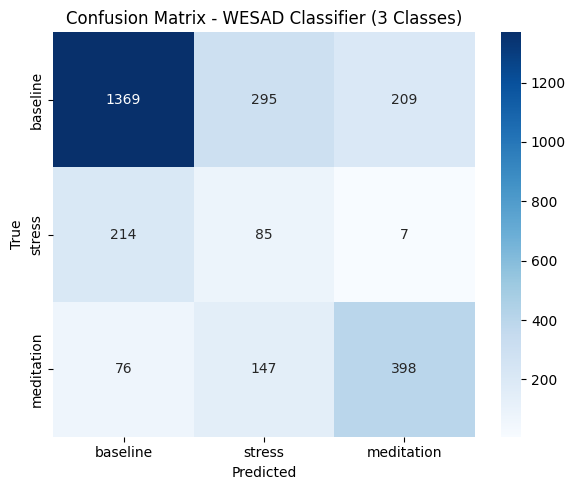

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_seq, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - WESAD Classifier (3 Classes)")
plt.tight_layout()
plt.show()
